### **1. Importing Libraries**





In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
%matplotlib inline


### **2. Loading & Processing Data**





In [16]:
def data_load():
  (X_train, y_train),(X_test, y_test) = tf.keras.datasets.cifar10.load_data()
  X_train = X_train/255.0
  X_test = X_test/255.0
  return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test =data_load()

In [17]:
print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


####  **Data Augmentation**





In [18]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            horizontal_flip=True)

In [19]:
## Batching and shuffling Data

def data_generatore(X_train, y_train, X_test, y_test):
  train_ds = datagen.flow(X_train, y_train, 32)
  test_ds = tf.data.Dataset.from_tensor_slices(
      (X_test, y_test)).shuffle(10000).batch(32)
  return train_ds, test_ds
train_ds,test_ds = data_generatore(X_train, y_train, X_test, y_test)

training_steps = int(len(X_train)/32)

### **3. Creating Class with tf.keras subclass Model**

In [29]:
class MyModel(Model):
  def __init__(self):
    super().__init__()
    
    self.conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')
    self.conv1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')
    self.conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')
    self.conv2_1 = Conv2D(64, (3, 3), activation='relu', padding='same')
    self.conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')
    self.conv3_1 = Conv2D(128, (3, 3), activation='relu', padding='same')
    self.batchnorm1 = BatchNormalization()
    self.batchnorm2 = BatchNormalization()
    self.batchnorm3 = BatchNormalization()
    self.batchnorm4 = BatchNormalization()
    self.batchnorm5 = BatchNormalization()
    self.batchnorm6 = BatchNormalization()
    self.flatten = Flatten()
    self.dropout = Dropout(0.3)
    self.maxpool = MaxPooling2D(2,2)
    self.gmaxpool = GlobalMaxPooling2D()
    self.d1 = Dense(1024, activation='relu')
    self.d2 = Dense(512, activation='relu')
    self.d3 = Dense(128, activation='relu')
    self.d4 = Dense(10, activation= 'softmax')
    
  def call(self, x):
    
    x = self.conv1(x)
    x = self.batchnorm1(x)
    #x = self.maxpool(x)
    x = self.conv1_1(x)
    x = self.batchnorm2(x)
    x = self.maxpool(x)

    x = self.conv2(x)
    x = self.batchnorm3(x)
    #x = self.maxpool(x)
    x = self.conv2_1(x)
    x = self.batchnorm4(x)
    x = self.maxpool(x)

    x = self.conv3(x)
    x = self.batchnorm5(x)
    #x = self.maxpool(x)
    x = self.conv3_1(x)
    x = self.batchnorm6(x)
    x = self.maxpool(x)
    #x = self.gmaxpool(x)

    x = self.flatten(x)
    x = self.d1(x)
    x = self.dropout(x)
    x = self.d2(x)
    #x = self.dropout(x)
    #x = self.d3(x)
    #x = self.dropout(x)
    return self.d4(x)

In [30]:
# creating instance of model
model = MyModel()

### **4. Optimizer and loss Function** 

In [31]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
Optimiser = tf.keras.optimizers.Adam()

### **5. Metrics For Loss and Acuracy**

In [32]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

### **6. Function for training and Testing**

In [33]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    prediction = model(images, training=True)
    loss = loss_object(labels,prediction)
  gradient = tape.gradient(loss, model.trainable_variables)
  Optimiser.apply_gradients(zip(gradient, model.trainable_variables))
  train_loss(loss)
  train_accuracy(labels, prediction)

In [34]:
@tf.function
def test_step(images, labels):
  prediction = model(images, training = False)
  t_loss = loss_object(labels, prediction)
  test_loss(t_loss)
  test_accuracy(labels, prediction)

### **7. Training Model**

In [35]:
EPOCHS = 50
Train_LOSS = []
TRain_Accuracy = []
Test_LOSS = []
Test_Accuracy = []

for epoch in range(EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()
  print(f'Epoch : {epoch+1}')

  count = 0  # variable to keep tab how much data steps of training

  for images, labels in tqdm(train_ds, total=training_steps, desc= 'training'):
    if count < training_steps:
      train_step(images, labels)
      count+=1
    else:
      break
  for test_images, test_labels in tqdm(test_ds, desc= 'testing'):
    test_step(test_images, test_labels)
    
  

  print(
      f'Loss: {train_loss.result()}, '
      f'Accuracy: {train_accuracy.result()*100}, '
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result()*100}'
  )

  Train_LOSS.append(train_loss.result())
  TRain_Accuracy.append(train_accuracy.result()*100)
  Test_LOSS.append(test_loss.result())
  Test_Accuracy.append(test_accuracy.result()*100)

  ### Implementing  CallBack

  if epoch==0:
    min_Loss = test_loss.result()
    min_Accuracy = test_accuracy.result()*100
  elif (min_Loss>test_loss.result()):
    if (min_Accuracy <= test_accuracy.result()*100) :
      min_Loss = test_loss.result()
      min_Accuracy = ( test_accuracy.result()*100)
      #path = 'BS_'+ str(epoch + 1)+'_'+ str(min_Loss)+'_'+str(min_Accuracy) +'.h5'
      print(f"Saving Best Model {epoch+1}")
      #path = f'/content/drive/MyDrive/Colab Notebooks/Model/BS_{epoch + 1}_{train_loss.result()}_{train_accuracy.result()*100}.h5'
      path = f'/content/drive/MyDrive/Colab Notebooks/Model/BestModel.h5'  
  

      model.save_weights(path)                            # Saving Model To drive
      #tf.keras.models.save_model(model, path, overwrite=True, include_optimizer=True, save_format='tf',
      #                           signatures=None, options=None, save_traces=True)
 

Epoch : 1



Loss: 1.4245644807815552, Accuracy: 49.31578063964844, Test Loss: 1.0560044050216675, Test Accuracy: 62.66999816894531
Epoch : 2



Loss: 0.9871495366096497, Accuracy: 65.64100646972656, Test Loss: 0.9018194079399109, Test Accuracy: 69.41000366210938
Saving Best Model 2
Epoch : 3



Loss: 0.8276444673538208, Accuracy: 71.38884735107422, Test Loss: 0.8020093441009521, Test Accuracy: 72.22000122070312
Saving Best Model 3
Epoch : 4



Loss: 0.7284951210021973, Accuracy: 75.12403869628906, Test Loss: 0.7570319175720215, Test Accuracy: 73.8699951171875
Saving Best Model 4
Epoch : 5



Loss: 0.6666842699050903, Accuracy: 77.46678924560547, Test Loss: 0.6608127951622009, Test Accuracy: 78.01000213623047
Saving Best Model 5
Epoch : 6



Loss: 0.620658278465271, Accuracy: 78.86724090576172, Test Loss: 0.6126284003257751, Test Accuracy: 79.5199966430664
Saving Best Model 6
Epoch : 7



Loss: 0.5835360884666443, Accuracy: 80.40773010253906, Test Loss: 0.5515653491020203, Test Accuracy: 81.56999969482422
Saving Best Model 7
Epoch : 8



Loss: 0.5415734052658081, Accuracy: 81.58010864257812, Test Loss: 0.6358458995819092, Test Accuracy: 79.32999420166016
Epoch : 9



Loss: 0.5105924606323242, Accuracy: 82.71646881103516, Test Loss: 0.5782051086425781, Test Accuracy: 81.0
Epoch : 10



Loss: 0.489273339509964, Accuracy: 83.40469360351562, Test Loss: 0.7076230049133301, Test Accuracy: 77.93000030517578
Epoch : 11



Loss: 0.4653657078742981, Accuracy: 84.28297424316406, Test Loss: 0.6217707991600037, Test Accuracy: 80.29999542236328
Epoch : 12



Loss: 0.450883150100708, Accuracy: 84.6791000366211, Test Loss: 0.503380537033081, Test Accuracy: 83.59000396728516
Saving Best Model 12
Epoch : 13



Loss: 0.4292602241039276, Accuracy: 85.48735046386719, Test Loss: 0.5636516213417053, Test Accuracy: 81.70999908447266
Epoch : 14



Loss: 0.41078221797943115, Accuracy: 86.0515365600586, Test Loss: 0.4629890024662018, Test Accuracy: 84.5999984741211
Saving Best Model 14
Epoch : 15



Loss: 0.3979068696498871, Accuracy: 86.62171936035156, Test Loss: 0.7027029991149902, Test Accuracy: 78.81999969482422
Epoch : 16



Loss: 0.3837743401527405, Accuracy: 86.95982360839844, Test Loss: 0.5184407234191895, Test Accuracy: 83.67000579833984
Epoch : 17



Loss: 0.3744572103023529, Accuracy: 87.36195373535156, Test Loss: 0.5566509962081909, Test Accuracy: 82.45000457763672
Epoch : 18



Loss: 0.3587043881416321, Accuracy: 87.83810424804688, Test Loss: 0.45948463678359985, Test Accuracy: 85.12999725341797
Saving Best Model 18
Epoch : 19



Loss: 0.3466527760028839, Accuracy: 88.27424621582031, Test Loss: 0.4698164165019989, Test Accuracy: 85.08999633789062
Epoch : 20



Loss: 0.33771559596061707, Accuracy: 88.47831726074219, Test Loss: 0.5017533898353577, Test Accuracy: 84.29000091552734
Epoch : 21



Loss: 0.3270095884799957, Accuracy: 88.8784408569336, Test Loss: 0.47568225860595703, Test Accuracy: 85.04999542236328
Epoch : 22



Loss: 0.31792351603507996, Accuracy: 89.23055267333984, Test Loss: 0.43977347016334534, Test Accuracy: 85.61000061035156
Saving Best Model 22
Epoch : 23



Loss: 0.30915567278862, Accuracy: 89.48463439941406, Test Loss: 0.45516207814216614, Test Accuracy: 85.8699951171875
Epoch : 24



Loss: 0.299307644367218, Accuracy: 89.95478820800781, Test Loss: 0.4180544912815094, Test Accuracy: 86.65999603271484
Saving Best Model 24
Epoch : 25



Loss: 0.2938999533653259, Accuracy: 90.09283447265625, Test Loss: 0.48281875252723694, Test Accuracy: 85.39999389648438
Epoch : 26



Loss: 0.27922651171684265, Accuracy: 90.42493438720703, Test Loss: 0.4560721814632416, Test Accuracy: 86.08999633789062
Epoch : 27



Loss: 0.28019335865974426, Accuracy: 90.6310043334961, Test Loss: 0.46146947145462036, Test Accuracy: 85.62999725341797
Epoch : 28



Loss: 0.26867353916168213, Accuracy: 90.86708068847656, Test Loss: 0.4454987347126007, Test Accuracy: 86.33000183105469
Epoch : 29



Loss: 0.2654653787612915, Accuracy: 90.9951171875, Test Loss: 0.4789322316646576, Test Accuracy: 84.88999938964844
Epoch : 30



Loss: 0.2597012221813202, Accuracy: 91.12516021728516, Test Loss: 0.4331144392490387, Test Accuracy: 86.58000183105469
Epoch : 31



Loss: 0.253047376871109, Accuracy: 91.4892807006836, Test Loss: 0.4476575255393982, Test Accuracy: 86.22000122070312
Epoch : 32



Loss: 0.24975861608982086, Accuracy: 91.60731506347656, Test Loss: 0.6310158371925354, Test Accuracy: 83.0
Epoch : 33



Loss: 0.24285581707954407, Accuracy: 91.65533447265625, Test Loss: 0.4198448956012726, Test Accuracy: 86.79999542236328
Epoch : 34



Loss: 0.24134331941604614, Accuracy: 91.77936553955078, Test Loss: 0.379999577999115, Test Accuracy: 87.81999969482422
Saving Best Model 34
Epoch : 35



Loss: 0.23014788329601288, Accuracy: 91.9554214477539, Test Loss: 0.4426461160182953, Test Accuracy: 86.72999572753906
Epoch : 36



Loss: 0.2233271449804306, Accuracy: 92.53560638427734, Test Loss: 0.4446066915988922, Test Accuracy: 87.20999908447266
Epoch : 37



Loss: 0.22328004240989685, Accuracy: 92.35154724121094, Test Loss: 0.4344330430030823, Test Accuracy: 86.87999725341797
Epoch : 38



Loss: 0.21868951618671417, Accuracy: 92.59162902832031, Test Loss: 0.4241502583026886, Test Accuracy: 87.38999938964844
Epoch : 39



Loss: 0.21700353920459747, Accuracy: 92.60163116455078, Test Loss: 0.39807450771331787, Test Accuracy: 87.8499984741211
Epoch : 40



Loss: 0.20862634479999542, Accuracy: 92.93974304199219, Test Loss: 0.4519316554069519, Test Accuracy: 87.18000030517578
Epoch : 41



Loss: 0.2126120626926422, Accuracy: 92.88772583007812, Test Loss: 0.4353176951408386, Test Accuracy: 87.47000122070312
Epoch : 42



Loss: 0.20223850011825562, Accuracy: 93.26384735107422, Test Loss: 0.388556569814682, Test Accuracy: 88.0
Epoch : 43



Loss: 0.20387856662273407, Accuracy: 92.98975372314453, Test Loss: 0.43775510787963867, Test Accuracy: 86.98999786376953
Epoch : 44



Loss: 0.19860520958900452, Accuracy: 93.17381286621094, Test Loss: 0.40506094694137573, Test Accuracy: 88.19000244140625
Epoch : 45



Loss: 0.1927514523267746, Accuracy: 93.48991394042969, Test Loss: 0.39231789112091064, Test Accuracy: 88.25
Epoch : 46



Loss: 0.19480788707733154, Accuracy: 93.32986450195312, Test Loss: 0.3989419937133789, Test Accuracy: 88.34000396728516
Epoch : 47



Loss: 0.1908193826675415, Accuracy: 93.51992797851562, Test Loss: 0.4264327883720398, Test Accuracy: 87.77999877929688
Epoch : 48



Loss: 0.18282918632030487, Accuracy: 93.77001190185547, Test Loss: 0.406695693731308, Test Accuracy: 88.61000061035156
Epoch : 49



Loss: 0.18237406015396118, Accuracy: 93.81602478027344, Test Loss: 0.46124982833862305, Test Accuracy: 87.33000183105469
Epoch : 50



Loss: 0.18261468410491943, Accuracy: 93.76200103759766, Test Loss: 0.39197689294815063, Test Accuracy: 88.26000213623047


### **8. Ploting Loss and Accuracy Per Iteration**

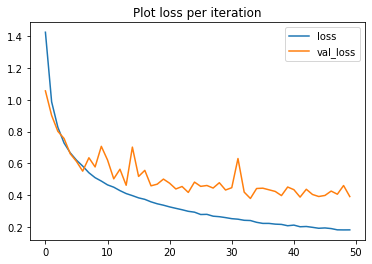

In [36]:
# Plot loss per iteration
plt.plot(Train_LOSS, label='loss')
plt.plot(Test_LOSS, label='val_loss')
plt.title('Plot loss per iteration')
plt.legend()

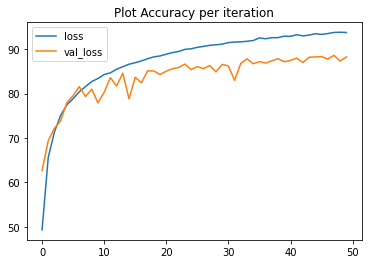

In [37]:
# Plot Accuracy per iteration
plt.plot(TRain_Accuracy, label='loss')
plt.plot(Test_Accuracy, label='val_loss')
plt.title('Plot Accuracy per iteration')
plt.legend()




*   Template From TensorFlow 2 quickstart for experts
*   





